# ALUNOS:


Ana Elisa

Arthur Nunes

Bruno Felipe

Caio Cesar

Lucas Camelo

Nicole Fava

# Random Forest Regressor — Air Quality (UCI)

Notebook de regressão multilinear com base no dataset Air Quality (UCI). Inclui: descrição do conjunto, EDA, preparação, modelo principal RandomForestRegressor, com correlação, importância de features e scatter y_real vs y_pred.

## Descrição do Dataset
- Nome: Air Quality (UCI)
- Tarefa: Regressão (multivariada, série temporal)
- Instâncias: 9358 (médias horárias de março/2004 a fevereiro/2005)
- Atributos: 15
- Alvos de referência (analisador): CO (GT), NMHC (GT), C6H6 (GT), NOx (GT), NO2 (GT)
- Sensores: PT08.S1 (CO), PT08.S2 (NMHC), PT08.S3 (NOx), PT08.S4 (NO2), PT08.S5 (O3)
- Meteorologia: Temperatura (T), Umidade Relativa (RH), Umidade Absoluta (AH)
- Datas/Tempos: colunas de data e hora
- Valores faltantes codificados: -200
- Observações: há sensibilidades cruzadas e drift de sensores reportados na literatura (De Vito et al., 2008).

> Todas as análises a seguir usam as mesmas variáveis de entrada (sensores + clima) para estimar o alvo contínuo `c6h6_gt` (benzeno). Caso queira avaliar outro gás, basta ajustar `TARGET_COL`, refazendo todo o fluxo.


In [1]:
def import_or_install(package):
    try:
        __import__(package)
    except ImportError:
        import sys, subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        __import__(package)

import_or_install('numpy')
import_or_install('pandas')
import_or_install('seaborn')
import_or_install('ucimlrepo')
import_or_install('matplotlib')

In [2]:
try:
    import sklearn
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'scikit-learn'])
    import sklearn

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

sns.set_theme(style='whitegrid', palette='deep', context='notebook')

## Carregamento e Preparação
- Carrega via ucimlrepo (id=360).
- Concatena features e targets.
- Renomeia colunas (snake_case).
- Substitui -200 por NaN nas numéricas.
- Extrai hora/mês/dia-da-semana se `date` e `time` estiverem presentes.


In [3]:
from ucimlrepo import fetch_ucirepo

air_quality = fetch_ucirepo(id=360)
TARGET_ORIGINAL = 'C6H6(GT)'

features_raw = air_quality.data.features
targets_raw = air_quality.data.targets

df = pd.concat([features_raw, targets_raw], axis=1)
orig_cols = df.columns.tolist()

# Renomeia colunas para snake_case e remove caracteres especiais
df.columns = (pd.Series(df.columns)
               .str.strip().str.lower()
               .str.replace(r'[^0-9a-zA-Z]+', '_', regex=True)
               .str.strip('_'))

# Trata -200 como NaN nas numéricas
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].replace(-200, np.nan)

# Extrai atributos de tempo se existir date/time
if {'date', 'time'}.issubset(df.columns):
    dt = pd.to_datetime(df['date'] + ' ' + df['time'], errors='coerce', dayfirst=True)
    df['hour'] = dt.dt.hour
    df['month'] = dt.dt.month
    df['dayofweek'] = dt.dt.dayofweek

print('Shape (linhas, colunas):', df.shape)

mapping = pd.DataFrame({
    'original': orig_cols,
    'renomeada': df.columns[:len(orig_cols)]
})

display(mapping)
display(df.head())

Shape (linhas, colunas): (9357, 18)


,original,renomeada
0,Date,date
1,Time,time
2,CO(GT),co_gt
3,PT08.S1(CO),pt08_s1_co
4,NMHC(GT),nmhc_gt
5,C6H6(GT),c6h6_gt
6,PT08.S2(NMHC),pt08_s2_nmhc
7,NOx(GT),nox_gt
8,PT08.S3(NOx),pt08_s3_nox
9,NO2(GT),no2_gt


,date,time,co_gt,pt08_s1_co,nmhc_gt,c6h6_gt,pt08_s2_nmhc,nox_gt,pt08_s3_nox,no2_gt,pt08_s4_no2,pt08_s5_o3,t,rh,ah,hour,month,dayofweek
0,3/10/2004,18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,18.0,10.0,6.0
1,3/10/2004,19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,19.0,10.0,6.0
2,3/10/2004,20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,20.0,10.0,6.0
3,3/10/2004,21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,21.0,10.0,6.0
4,3/10/2004,22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,22.0,10.0,6.0


## Seleção de Alvo e Atributos
- Alvo padrão: `c6h6_gt` (benzeno).
- Atributos: sensores PT08 + clima (t, rh, ah) e, se presentes, hora/mês/dia-da-semana.
- Remoção de linhas com NaN nas colunas usadas.


In [4]:
TARGET_COL = 'c6h6_gt'

candidate_features = ['pt08_s1_co','pt08_s2_nmhc','pt08_s3_nox','pt08_s4_no2','pt08_s5_o3','t','rh','ah']

for extra in ['hour','month','dayofweek']:
    if extra in df.columns:
        candidate_features.append(extra)

features = [c for c in candidate_features if c in df.columns]
assert TARGET_COL in df.columns, f'Alvo {TARGET_COL!r} não encontrado.'

df_used = df[features + [TARGET_COL]].dropna().copy()
print('Atributos usados:', features)
print('Shape final usado:', df_used.shape)
display(df_used.head(100))


Atributos usados: ['pt08_s1_co', 'pt08_s2_nmhc', 'pt08_s3_nox', 'pt08_s4_no2', 'pt08_s5_o3', 't', 'rh', 'ah', 'hour', 'month', 'dayofweek']
Shape final usado: (3418, 12)


,pt08_s1_co,pt08_s2_nmhc,pt08_s3_nox,pt08_s4_no2,pt08_s5_o3,t,rh,ah,hour,month,dayofweek,c6h6_gt
0,1360.0,1046.0,1056.0,1692.0,1268.0,13.6,48.9,0.7578,18.0,10.0,6.0,11.9
1,1292.0,955.0,1174.0,1559.0,972.0,13.3,47.7,0.7255,19.0,10.0,6.0,9.4
2,1402.0,939.0,1140.0,1555.0,1074.0,11.9,54.0,0.7502,20.0,10.0,6.0,9.0
3,1376.0,948.0,1092.0,1584.0,1203.0,11.0,60.0,0.7867,21.0,10.0,6.0,9.2
4,1272.0,836.0,1205.0,1490.0,1110.0,11.2,59.6,0.7888,22.0,10.0,6.0,6.5
...,...,...,...,...,...,...,...,...,...,...,...,...
554,1693.0,1439.0,618.0,2083.0,1723.0,19.4,42.5,0.9483,20.0,2.0,2.0,25.4
555,1374.0,1121.0,771.0,1685.0,1399.0,18.5,43.0,0.9074,21.0,2.0,2.0,14.1
556,1287.0,982.0,841.0,1582.0,1291.0,17.8,47.0,0.9467,22.0,2.0,2.0,10.1
557,1408.0,1052.0,761.0,1684.0,1443.0,16.8,53.2,1.0100,23.0,2.0,2.0,12.1


## Split Treino/Teste
### O modelo aprende relações entre sensores de qualidade do ar e concentração de benzeno, depois testa sua capacidade preditiva.

In [5]:
X = df_used[features]
y = df_used[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [6]:
# treina o modelo Random Forest e avalia seu desempenho

rf = RandomForestRegressor(
    n_estimators=100,   # 100 árvores de decisão
    max_depth=None,     # sem limite de profundidade
    random_state=42,    # reprodutibilidade
    n_jobs=-1           # usa todos os processadores
)

#Treina o modelo com os dados de treino.
rf.fit(X_train, y_train)

# Gera previsões para o conjunto de teste.
y_pred_rf = rf.predict(X_test)

# Calcula as métricas de desempenho:
# MSE: erro quadrático médio (quanto menor, melhor)
#R²: coeficiente de determinação (quanto mais próximo de 1, melhor)
mse = mean_squared_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

Mean Squared Error (MSE): 0.01
R-squared (R²): 1.00


In [7]:
#exibe o ranking de importância das features do modelo treinado

importances = rf.feature_importances_
feature_names = X.columns
sorted_indices = importances.argsort()[::-1]
print("\nRanking das features por importância:")
for i in sorted_indices:
    print(f"{feature_names[i]}: {importances[i]:.4f}")


Ranking das features por importância:
pt08_s2_nmhc: 0.9996
pt08_s3_nox: 0.0001
pt08_s4_no2: 0.0000
pt08_s5_o3: 0.0000
t: 0.0000
hour: 0.0000
rh: 0.0000
pt08_s1_co: 0.0000
ah: 0.0000
dayofweek: 0.0000
month: 0.0000


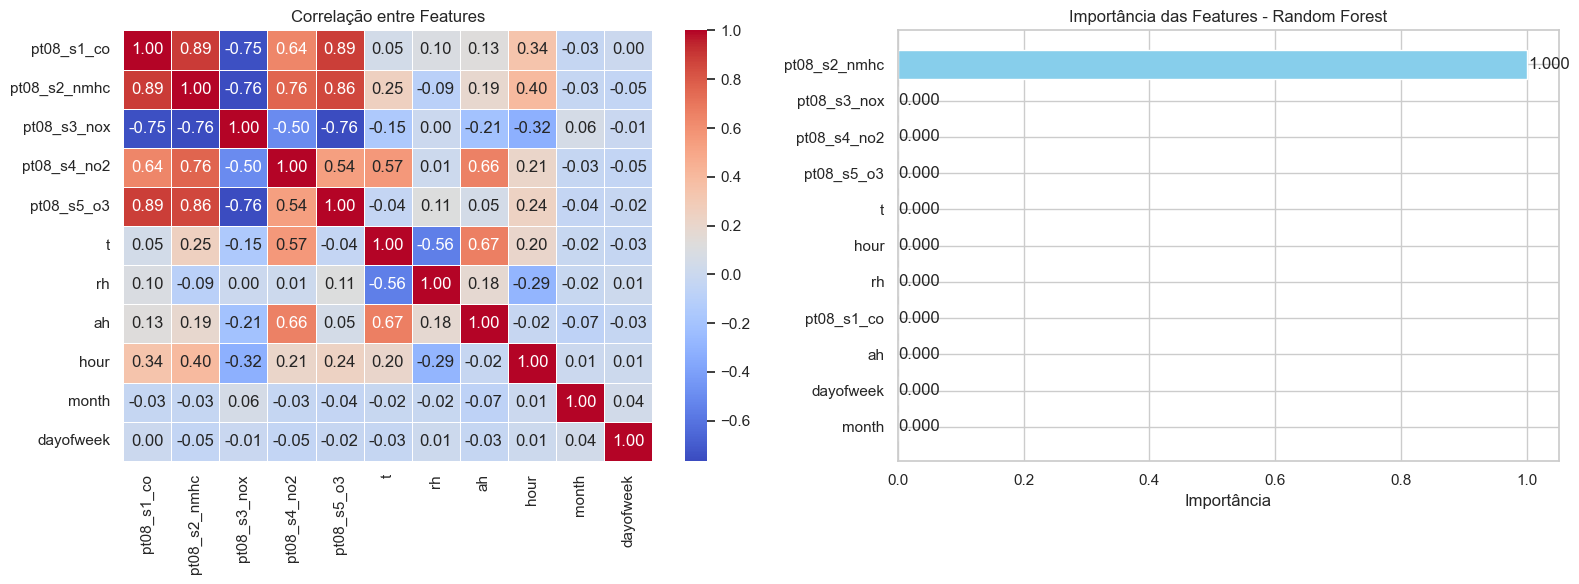

In [8]:
# cria duas visualizações lado a lado: matriz de correlação e gráfico de importância das features

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(X.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, ax=axes[0])
axes[0].set_title("Correlação entre Features")

sorted_features = [feature_names[i] for i in sorted_indices]
sorted_importances = importances[sorted_indices]
bars = axes[1].barh(sorted_features, sorted_importances, color="skyblue")
axes[1].set_xlabel("Importância")
axes[1].set_title("Importância das Features - Random Forest")
axes[1].invert_yaxis()

for bar in bars:
    width = bar.get_width()
    axes[1].text(
        width + 0.001, bar.get_y() + bar.get_height() / 2, f"{width:.3f}", va="center"
    )

plt.tight_layout()
plt.show()

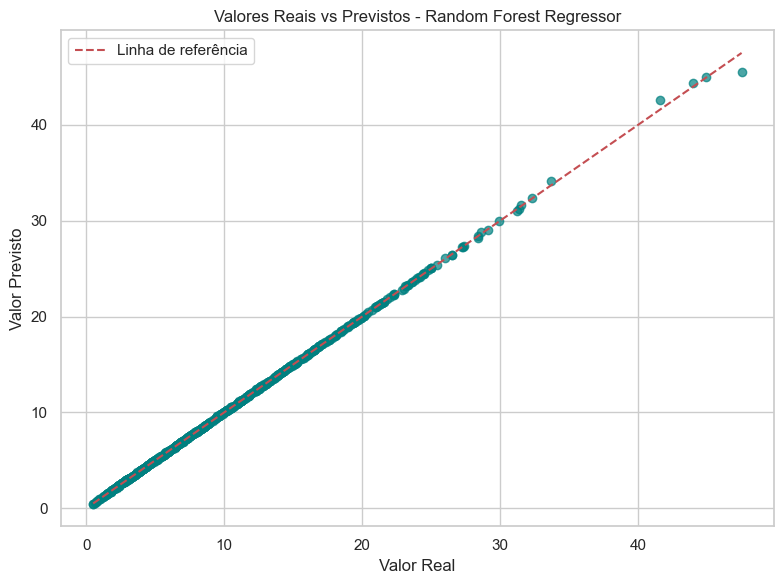

In [9]:
# cria um gráfico de dispersão comparando valores reais vs previstos do modelo

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.7, color="teal")
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    "r--",
    label="Linha de referência",
)
plt.xlabel("Valor Real")
plt.ylabel("Valor Previsto")
plt.title("Valores Reais vs Previstos - Random Forest Regressor")
plt.legend()
plt.tight_layout()
plt.show()